In [117]:
from typing import Union
from typing import Sequence
from typing import Any
from typing import Callable

import numpy as np

from numba import njit
from numpy.typing import NDArray


# ! ----------------- !
# ! --- Henon map --- !
# ! ----------------- !


@njit
def henon_map(
    u: NDArray[np.float64], 
    parameters: Union[NDArray[np.float64], Sequence[float]]
) -> NDArray[np.float64]:
    a, b = parameters
    x, y = u
    x_new = y #1 - a * x**2 + y
    y_new = -x + 0.47*y + y**2 #b * x
    return np.stack((x_new, y_new))

In [118]:
xs = np.array([[0.1, 0.2], [0.14, 0.2], [0.1, 0.22]]).T
ks = np.array([0.1, 1.0])

henon_map(xs, ks)

array([[ 0.2   ,  0.2   ,  0.22  ],
       [ 0.034 , -0.006 ,  0.0518]])

In [119]:
@njit
def exponential_filter(
    length:int,
    degree:float=1.0
) -> NDArray[np.float64]:
    """
    Generate exponential filter

    Parameters
    ----------
    length: int, postive
        filter length
    degree: float, default=1.0
        filter degree

    Returns
    -------
    NDArray[np.float64]

    """
    ts = np.linspace(0.0, (length - 1.0)/length, length)
    ws = np.exp(-1.0/((1.0 - ts)**degree*ts**degree))
    return ws/np.sum(ws)

In [120]:
ws = exponential_filter(2**10)
ws

array([0.00000000e+000, 0.00000000e+000, 2.23272049e-224, ...,
       2.93764791e-150, 2.23272049e-224, 0.00000000e+000])

In [121]:
def rns(
    d: int,
    u: NDArray[np.float64],
    weights: NDArray[np.float64],
    mapping: Callable[[NDArray[np.float64], NDArray[np.float64]], NDArray[np.float64]],
    parameters: Union[NDArray[np.float64], Sequence[float]]
) -> NDArray[np.float64]:
    """
    Estimate rotation numbers

    Parameters
    ----------
    u: NDArray[np.float64]
    weights: NDArray[np.float64]
    mapping: Callable[[NDArray[np.float64], NDArray[np.float64]], NDArray[np.float64]]

    Returns
    -------
    NDArray[np.float64]

    """
    factor = 2.0*np.pi
    qs, ps = np.reshape(u, (2, d // 2, -1))
    initial = np.arctan2(qs, ps)
    rns = np.zeros_like(initial)
    for w in ws:
        u = mapping(u, parameters)
        qs, ps = np.reshape(u, (2, d // 2, -1))
        current = np.arctan2(qs, ps)
        rns += w*((current - initial) % factor)
        initial = current
    return u, rns/factor

@njit
def rotation_numbers(
    d: int,
    u: NDArray[np.float64],
    weights: NDArray[np.float64],
    mapping: Callable[[NDArray[np.float64], NDArray[np.float64]], NDArray[np.float64]],
    parameters: Union[NDArray[np.float64], Sequence[float]]
) -> NDArray[np.float64]:
    """
    Estimate rotation numbers

    Parameters
    ----------
    u: NDArray[np.float64]
    weights: NDArray[np.float64]
    mapping: Callable[[NDArray[np.float64], NDArray[np.float64]], NDArray[np.float64]]

    Returns
    -------
    NDArray[np.float64]

    """
    factor = 2.0*np.pi
    qs, ps = np.reshape(u, (2, d // 2, -1))
    initial = np.arctan2(qs, ps)
    rns = np.zeros_like(initial)
    for w in ws:
        u = mapping(u, parameters)
        qs, ps = np.reshape(u, (2, d // 2, -1))
        current = np.arctan2(qs, ps)
        rns += w*((current - initial) % factor)
        initial = current
    return u, rns/factor

In [122]:
n = 1001

qs = np.linspace(-1.0, 1.0, n)
ps = np.linspace(-1.0, 1.0, n)
xs = np.stack(np.meshgrid(qs, ps, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1).T
xs

array([[-1.   , -0.998, -0.996, ...,  0.996,  0.998,  1.   ],
       [-1.   , -1.   , -1.   , ...,  1.   ,  1.   ,  1.   ]])

In [123]:
%%time
out = rns(2, xs, ws, henon_map, ks)

CPU times: user 21.1 s, sys: 34.9 ms, total: 21.1 s
Wall time: 21.1 s


In [124]:
%%time
out = rotation_numbers(2, xs, ws, henon_map, ks)

CPU times: user 20.3 s, sys: 161 ms, total: 20.5 s
Wall time: 20.2 s


In [125]:
out[1].squeeze()

array([nan, nan, nan, ..., nan, nan, nan])

In [126]:
from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

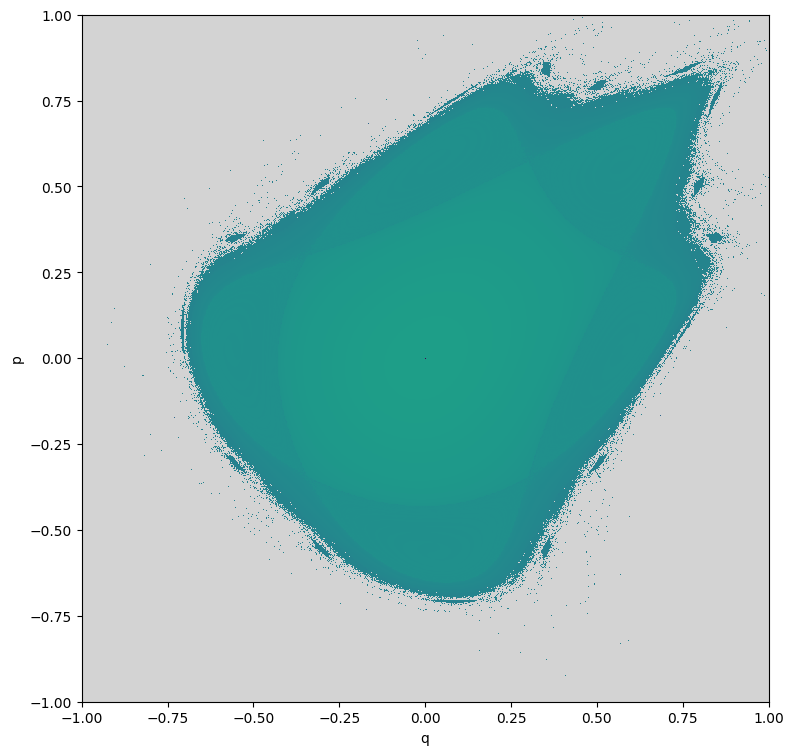

In [132]:
# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(out[1].reshape(n, n), aspect='equal', vmin=0.1, vmax=0.3, origin='lower', cmap=cmap, interpolation='nearest', extent=(-1.0, 1.0, -1.0, 1.0))
plt.xlabel('q')
plt.ylabel('p')
plt.tight_layout()
plt.show()

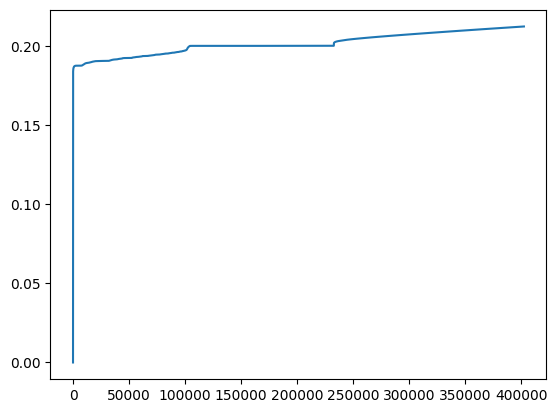

In [131]:
plt.plot(np.sort(out[1].flatten()))